# Random Features

## Inputs loading

In [6]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime as datetime
import statsmodels.api as sm

#### Read from the database

In [ ]:
conn = sqlite3.connect('db2023.db')
query = "SELECT * FROM Z_R_matrices"
results = pd.read_sql_query(query, conn)

# Columns to use for ratios
cols_ratios = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
               'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax',
               'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
               'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt',
               'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
               'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be',
               'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
               'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn',
               'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale',
               'accrual', 'ptb', 'PEG_trailing', 'divyield']

# Columns for lagged returns
cols_lags = [f'ret_lag_{i}' for i in range(1, 13)]

# Fetch all distinct dates from the table
dates = pd.read_sql_query('SELECT DISTINCT date FROM Z_R_matrices', conn)
dates_list = dates['date'].tolist()
dates_list.sort()

#### Read from the CSV file

In [7]:
# Read the CSV file into a DataFrame
results = pd.read_csv("Z_R_matrices.csv")
# Columns to use for ratios
cols_ratios = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
               'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax',
               'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
               'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt',
               'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
               'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be',
               'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
               'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn',
               'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale',
               'accrual', 'ptb', 'PEG_trailing', 'divyield']

# Columns for lagged returns
cols_lags = [f'ret_lag_{i}' for i in range(1, 13)]

# Convert the 'date' column to datetime
results['date'] = pd.to_datetime(results['date'])

# Extract distinct dates from the DataFrame
dates_list = results['date'].drop_duplicates().sort_values().tolist()


## Functions

In [245]:
def random_weights(d,L,weight_type = "unif_B^d", seed = 0, nu = None):
    """
    Generate a matrix of random weights according to a specified distribution.

    Parameters:
    -----------
    d : int
        The dimensionality of each weight vector (number of rows in the output matrix).
    
    L : int
        The number of weight vectors to generate (number of columns in the output matrix).
    
    weight_type : str, optional, default="unif_B^d"
        The type of random weights to generate. Options include:
        - "gaussian": Standard normal distribution.
        - "unif_S^d-1": Uniformly distributed on the (d-1)-dimensional sphere S^(d-1).
        - "unif_B^d": Uniformly distributed inside the unit ball B^d_1.
        - "t-student": standard d-dimensional t-student distribution with nu degrees of freedom.
        - "gonon": Uniformly distributed inside the unit ball B^d_1, with uniform biases
                   over [-sqrt(d),sqrt(d)],  as R = L^{1/(2k-2\eps+1) ~ 1.
    
    seed : int, optional, default=0
        The seed for the random number generator, ensuring reproducibility.
    
    nu : int, optional, default = None
        degrees of freedom for the t-student distribution.


    Returns:
    --------
    W : numpy.ndarray
        A (d x L) matrix of random weights generated according to the specified distribution.
    xi : np.ndarray, optional
        A L-dimensional vector of random biases, if sample_biases is True.

    Raises:
    -------
    ValueError
        If an invalid `weight_type` is provided.

    Notes:
    ------
    - If `weight_type` is "unif_S^d-1", the vectors are uniformly distributed over the surface
      of the unit sphere S^(d-1), meaning they have a unit norm.
    - If `weight_type` is "unif_B^d", the vectors are uniformly distributed inside the unit ball
      B^d_1, which includes scaling by a random radial distance.
    """

    # set the seed
    np.random.seed(seed)

    # sample normal
    W = np.random.normal(size = (d,L))

    if weight_type == "gaussian":
        return W, 0
    elif weight_type == "unif_S^d-1":
        # Sample uniform over the Sphere S^{d-1}, i.e. we sample a random direction.
        W = (1/np.linalg.norm(W, axis = 0, ord = 2, keepdims = True)) * W
        return W, 0
    elif weight_type == "unif_B^d":
        # Sample uniform over the ball of radius one B^d_1.
        W = (1/np.linalg.norm(W, axis = 0, ord = 2, keepdims = True)) * W
        U = np.random.uniform(low = 0, high = 1, size = L)
        Rad = U ** (1/d)  
        W = Rad * W
        return W, 0
    elif (weight_type == "t-student") and (nu != None):
        chi_squared = np.random.chisquare(nu, size=L)
        W = W * np.sqrt(nu/chi_squared)
        return W, 0
    elif weight_type == "unif_B^d+bias":
        W = (1/np.linalg.norm(W, axis = 0, ord = 2, keepdims = True)) * W
        U = np.random.uniform(low = 0, high = 1, size = L)
        Rad = U ** (1/d)  
        W = Rad * W
        xi = np.random.uniform(low = -np.sqrt(d), high = np.sqrt(d), size = L)
        return [W , xi]
    else:
        raise ValueError("Invalid weight type.")

In [244]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Function to compute the instruments and associated factors
def compute_X_R_F(date,W, activation = "ReLU", normalize = False, winsorize = False, N = 1000, xi = 0):
    """
    Compute the instruments (X) and associated factors (F) based on the provided activation function
    and whether normalization is applied. The function takes in a specific date, a weight matrix (W),
    and the activation function to use.

    Parameters:
    -----------
    date : str or pd.Timestamp
        The date for which the instruments and factors should be computed.
        
    W : np.ndarray
        The weight matrix used in the linear transformation before applying the activation function.

    activation : str, optional (default="ReLU")
        The activation function to apply. Options are:
        - "ReLU": Applies the Rectified Linear Unit function (ReLU).
        - "tanh": Applies the hyperbolic tangent function (tanh).
        - "sigmoid": Applies the sigmoid function.
        An error is raised if an invalid activation function is provided.

    normalize : bool, optional (default=False)
        If True, the computed instruments (X) will be centered and normalized:
        - Centered: Mean-centered so that the average of each characteristic is zero.
        - Normalized: Scaled to have a unit one norm, meaning each column has a leverage of one dollar.

    winsorize : bool, optional (default=False)
        If True, the returns will be winsorized at 100% to remove the influence of outliers.
    
    N : int
        Normalizing constant for the factors, all factors get multiplied by these, can be set to average N_t.
    
    Returns:
    --------
    X : np.ndarray
        The computed instruments after applying the activation function and (optionally) normalization.

    R : np.ndarray
        The vector of adjusted returns (`R_e_adj`) for the specified date.

    F : np.ndarray
        The computed factors associated with the random features, obtained by multiplying 
        the transpose of X with R.

    Raises:
    -------
    ValueError:
        If an invalid activation function is specified.

    Notes:
    ------
    The function assumes that `results` is a pre-existing DataFrame with relevant data, 
    and that `cols_ratios` and `cols_lags` are predefined lists of column names. The 
    adjusted returns (`R_e_adj`) are expected to be a column in the DataFrame `results`.

    Example:
    --------
    X, R, F = compute_X_R_F("2023-01-31", W, activation="tanh", normalize=False)
    """
    Z_R = results[results["date"] == date]
    Z = Z_R[cols_ratios+cols_lags].to_numpy()
    R = Z_R["R_e_adj"].to_numpy()
    if activation == "ReLU":
        X = np.maximum(Z@W+xi,0) 
    elif activation == "tanh":
        X = np.tanh(Z@W+xi)
    elif activation == "sigmoid":
        X = sigmoid(Z@W+xi)
    elif activation == "cos_sin":
        W = W[:,:int(W.shape[1]/2)]
        X = np.concatenate((np.cos(Z @ W + xi), np.sin(Z @ W + xi)), axis=1)
    else:
        raise ValueError("Invalid activation.")
    N_t = R.shape[0]
    
    X = (N/N_t) * X
    if normalize:
        # center the derived characteristics
        X = X - np.mean(X, axis = 0, keepdims = True)
        # normalize so they have unit one norm (i.e. fixed leverage, one dollar exposure).
        X = (1/np.linalg.norm(X, axis = 0, ord = 1, keepdims = True)) * X 
        # X = (1/np.std(X, axis = 0, keepdims = True)) * X # alternative normalization
    
    if winsorize:
        R = np.minimum(R,1.0)
    # compute the factors associated with the random features
    F =  X.T @ R
    return X, R, F

In [267]:
# Main functions

def simple_split_SDF(F, W, dates_list, IS_size, L, activation, normalize, gammas, xi = 0):
    """
    Computes optimal portfolio coefficients and out-of-sample returns using a split between training (IS) and test set (OOS).

    Parameters:
    - F: Factor matrix (number of factors x number of time points).
    - W: random weights.
    - dates_list: List of dates corresponding to the time points in F.
    - IS_size: Size of the in-sample (IS) period.
    - L: Number of factors/portfolio coefficients.
    - activation: Activation function.
    - normalize: Boolean indicating whether to normalize (False by default).
    - gammas: List of egularization parameters.

    Returns:
    - b_hat_split: Optimal portfolio coefficients for each gamma.
    - R_P_OOS_split: Out-of-sample portfolio returns for each gamma.
    - SR_OOS_split: Out-of-sample Sharpe ratios for each gamma.
    - R_P_split_max: Portfolio returns corresponding to the maximum Sharpe ratio.
    """

    # Split between training (IS) and test set (OOS)
    F_IS = F[:, :IS_size]
    F_OOS = F[:, IS_size:]
    T_OOS = F_OOS.shape[1]

    # Regularization parameters
    
    n_gamma = len(gammas)
    # Compute optimal portfolio coefficients
    b_hat_split = np.zeros((n_gamma, L))
    B = F_IS.T @ F_IS
    for i, gamma in enumerate(gammas):
        b_hat_split[i, :] = (1 / IS_size) * F_IS @ np.linalg.solve((1 / IS_size) * B + gamma * np.eye(IS_size), np.ones(IS_size))

    # Construct a portfolio with unit leverage (i.e., ||w_t||_1 = 1 for all times)
    R_P_OOS_split = np.zeros((n_gamma, T_OOS))
    for t, date in enumerate(dates_list[IS_size:]):
        X_t, R, _ = compute_X_R_F(date, W, activation, normalize, xi = xi)
        v_t = X_t @ b_hat_split.T
        w_t = v_t / np.linalg.norm(v_t, axis=0, ord=1, keepdims=True)
        R_P_OOS_split[:, t] = w_t.T @ R

    # OOS Sharpe ratios

    # Choose the portfolio return with maximum Sharpe ratio
    SR_OOS_split = np.mean(R_P_OOS_split,axis = 1)/np.std(R_P_OOS_split,axis = 1) * np.sqrt(12)
    R_P_split_max = R_P_OOS_split[np.argmax(SR_OOS_split),:]

    return b_hat_split, R_P_OOS_split, SR_OOS_split, R_P_split_max

def rolling_window_SDF(F, W, dates_list, rolling_window_size, L, activation, normalize, gammas, xi = 0):
    """
    Computes optimal portfolio coefficients and out-of-sample returns using a rolling window approach.

    Parameters:
    - F: Factor matrix (number of factors x number of time points).
    - W: Random weights.
    - dates_list: List of dates corresponding to the time points in F.
    - rolling_window_size: Size of the rolling window for the in-sample (IS) period.
    - L: Number of factors/portfolio coefficients.
    - activation: Activation function.
    - normalize: Boolean indicating whether to normalize (False by default).
    - gammas: List of regularization parameters.

    Returns:
    - R_P_OOS_rolling: Out-of-sample portfolio returns for each gamma.
    - SR_OOS_rolling: Out-of-sample Sharpe ratios for each gamma.
    - R_P_rolling_max: Portfolio returns corresponding to the maximum Sharpe ratio.
    """

    # Number of out-of-sample time points
    T = len(dates_list)
    n_gamma = len(gammas)

    # Initialize array to store out-of-sample portfolio returns
    R_P_rolling = np.zeros((n_gamma, T - rolling_window_size))

    # Iterate over the rolling windows
    for t, date in enumerate(dates_list[rolling_window_size:], start=rolling_window_size):
        F_IS = F[:, t - rolling_window_size:t]

        # Initialize array to store optimal portfolio coefficients
        b_hat_rolling = np.zeros((n_gamma, L))
        # Compute optimal portfolio coefficients for each gamma
        B = F_IS.T @ F_IS
        for i, gamma in enumerate(gammas):
            b_hat_rolling[i, :] = (1 / rolling_window_size) * F_IS @ np.linalg.solve((1 / rolling_window_size) * B + gamma * np.eye(rolling_window_size), np.ones(rolling_window_size))
    
        # unit leverage returns
        X_t, R, _ = compute_X_R_F(date,W,activation,normalize, xi = xi)
        v_t = X_t @ b_hat_rolling.T
        w_t = v_t/np.linalg.norm(v_t, axis = 0, ord = 1)
        R_P_rolling[:,t-rolling_window_size] = w_t.T @ R

    # Compute OOS Sharpe ratios
    SR_rolling = np.mean(R_P_rolling, axis=1) / np.std(R_P_rolling, axis=1) * np.sqrt(12)
    R_P_rolling_max = R_P_rolling[np.argmax(SR_rolling),:]

    return R_P_rolling, SR_rolling, R_P_rolling_max


def different_number_factors_SDF(F, W, dates_list, rolling_window_size, d, multipliers, activation, normalize, gammas, xi = 0):
    """
    Computes out-of-sample Sharpe ratios for different number of random features and gammas using a rolling window approach.

    Parameters:
    - F: Factor matrix (number of factors x number of time points).
    - W: Random weights.
    - dates_list: List of dates corresponding to the time points in F.
    - rolling_window_size: Size of the rolling window for the in-sample (IS) period.
    - d: number of basic characteristics.
    - multipliers: List of multipliers to determine the number of random features.
    - activation: Activation function.
    - normalize: Boolean indicating whether to normalize (False by default).
    - gammas: List of regularization parameters.

    Returns:
    - SR_OOS_all: Out-of-sample Sharpe ratios for each number of random features and gammas.
    """
    T = len(dates_list)
    n_gamma = len(gammas)

    # Initialize array to store out-of-sample portfolio returns for each combination
    R_P_OOS_all = np.zeros((len(multipliers), n_gamma, T - rolling_window_size))

    for m_idx, multiplier in enumerate(multipliers):
        L_m = int(multiplier * d)
        for t, date in enumerate(dates_list[rolling_window_size:], start=rolling_window_size):
            F_IS = F[:L_m, t - rolling_window_size:t]

            b_hat = np.zeros((n_gamma, L_m))
            B = F_IS.T @ F_IS
            for i, gamma in enumerate(gammas):
                b_hat[i, :] = (1 / rolling_window_size) * F_IS @ np.linalg.solve((1 / rolling_window_size) * B + gamma * np.eye(rolling_window_size), np.ones(rolling_window_size))

            # Compute portfolio excess returns out of sample
            X, R, _ = compute_X_R_F(date,W,activation,normalize, xi = xi)
            X_t = X[:,:L_m]
            v_t = X_t @ b_hat.T
            w_t = v_t/np.linalg.norm(v_t, axis = 0, ord = 1)
            R_P_OOS_day = w_t.T @ R
            R_P_OOS_all[m_idx, :, t - rolling_window_size] = R_P_OOS_day
        print("Finished processing multiplier:", multiplier)

    # Compute OOS Sharpe ratios for each combination of factors and gammas
    SR_OOS_all = np.zeros((len(multipliers), n_gamma))
    for m_idx in range(len(multipliers)):
        for g_idx in range(n_gamma):
            R_P_OOS_mg = R_P_OOS_all[m_idx, g_idx, :]
            SR_OOS_all[m_idx, g_idx] = np.mean(R_P_OOS_mg) / np.std(R_P_OOS_mg) * np.sqrt(12)

    return SR_OOS_all


def rolling_cv_SDF(F, W, dates_list, rolling_window_size, gammas, activation, normalize, k_folds = 5, xi = 0):
    """
    Computes out-of-sample portfolio returns and Sharpe ratio using a rolling window approach with cross-validation 
    to select the optimal regularization parameter.

    Parameters:
    - F: Factor matrix (number of factors x number of time points).
    - W: Random weights.
    - dates_list: List of dates corresponding to the time points in F.
    - rolling_window_size: Size of the rolling window for the in-sample (IS) period.
    - gammas: List of regularization parameters.
    - activation: Activation function.
    - normalize: Boolean indicating whether to normalize (False by default).

    Returns:
    - R_P_OOS_cv: Out-of-sample portfolio returns.
    - SR_OOS_cv: Out-of-sample Sharpe ratio.
    - optimal_gammas: time series of gammas chosen by cross validation.
    """

    T = len(dates_list)
    n_gamma = len(gammas)
    # Initialize array to store out-of-sample portfolio returns
    R_P_OOS_cv = np.zeros(T - rolling_window_size)
    optimal_gammas = np.zeros(T - rolling_window_size)

    kf = KFold(n_splits=k_folds, shuffle=False)

    for t, date in enumerate(dates_list[rolling_window_size:], start=rolling_window_size):
        F_IS = F[:, t - rolling_window_size:t]

        # Every year we perform cross-validation to find the optimal gamma.
        if ((t - rolling_window_size) % 12 == 0):
            # Initialize variables to track the best gamma and its corresponding objective
            best_gamma = None

            # Store the average CV objective for each gamma
            sum_cv_objs = np.zeros(n_gamma)

            # Cross-validation loop
            for train_index, val_index in kf.split(F_IS.T):
                F_train, F_val = F_IS[:, train_index], F_IS[:, val_index]
                T_train = F_train.shape[1]

                # Compute B_train once for all gammas
                B_train = F_train.T @ F_train

                for idx, gamma in enumerate(gammas):
                    # Solve for b_hat using training data
                    b_hat_cv = (1 / T_train) * F_train @ np.linalg.solve((1 / T_train) * B_train + gamma * np.eye(T_train), np.ones(T_train))

                    # Compute the CV objective on validation data
                    ones_val = np.ones(F_val.shape[1])
                    prediction = b_hat_cv.T @ F_val
                    objective = np.mean((ones_val - prediction) ** 2)

                    # Accumulate the CV objective for averaging later
                    sum_cv_objs[idx] += objective

                # Average the objective across all folds
                avg_cv_objs = sum_cv_objs/k_folds

                # Find the gamma with the minimum average CV objective
                best_idx = np.argmin(avg_cv_objs)
                best_gamma = gammas[best_idx]

        # Store the best gamma for this window
        optimal_gammas[t - rolling_window_size] = best_gamma

        # Use the best gamma to compute b_hat and OOS returns
        B = F_IS.T @ F_IS
        b_hat_optimal = (1 / rolling_window_size) * F_IS @ np.linalg.solve((1 / rolling_window_size) * B + best_gamma * np.eye(rolling_window_size), np.ones(rolling_window_size))

        # Unit leverage returns
        X_t, R, _ = compute_X_R_F(date, W, activation, normalize, xi = xi)
        v_t = X_t @ b_hat_optimal
        w_t = v_t / np.linalg.norm(v_t, axis=0, ord=1)
        R_P_OOS_cv[t - rolling_window_size] = w_t.T @ R

    # Compute OOS Sharpe ratios
    SR_OOS_cv = np.mean(R_P_OOS_cv) / np.std(R_P_OOS_cv) * np.sqrt(12)

    return R_P_OOS_cv, SR_OOS_cv, optimal_gammas

In [11]:
# Plotting functions

def plot_SR(gammas,SR,path):
    # Plot the out-of-sample Sharpe ratios
    plt.plot(gammas, SR)
    plt.xscale('log')
    plt.xlabel('$\gamma$')
    plt.ylabel('OOS $SR$')
    plt.title('OOS Sharpe ratio ($\gamma$)')
    plt.savefig(path, format='png', dpi=300)
    plt.show()

def plot_yoy_return_over_time(return_series,path):
    """
    Computes and plots the YoY return over time for a given series of monthly returns using log returns.
    
    Parameters:
    - return_series: pd.Series, monthly returns indexed by datetime.
    
    Returns:
    - yearly_compounded_returns: pd.Series, the YoY compounded returns.
    """
    # Ensure the index is in datetime format
    return_series.index = pd.to_datetime(return_series.index)

    # Calculate log returns
    log_returns = np.log(1 + return_series)

    # Calculate the rolling 12-month sum of log returns
    rolling_log_returns = log_returns.rolling(window=12).sum()

    # Convert back to regular returns
    yearly_compounded_returns = np.exp(rolling_log_returns) - 1

    # Convert to percentage
    yearly_compounded_returns = yearly_compounded_returns * 100
    yearly_compounded_returns =yearly_compounded_returns.dropna()

    # Plot the yearly compounded return over time
    plt.figure(figsize=(12, 6))
    plt.plot(yearly_compounded_returns)
    plt.xlabel('Date')
    plt.ylabel('YoY Return (%)')
    plt.title('YoY Return Over Time')

    # Set x-axis major ticks to show each year
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set minor ticks to show every month
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.xlim([yearly_compounded_returns.index[0], yearly_compounded_returns.index[-1]])

    plt.grid(True)
    plt.savefig(path, format='png', dpi=300)
    plt.show()

    return yearly_compounded_returns


def plot_cumulative_return(return_series,path):
    """
    Computes and plots the cumulative return over time for a given series of monthly returns.
    
    Parameters:
    - return_series: pd.Series, monthly returns indexed by datetime.
    
    Returns:
    - cumulative_returns: pd.Series, the cumulative returns.
    """
    # Ensure the index is in datetime format
    return_series.index = pd.to_datetime(return_series.index)
    
    # Calculate the cumulative return over time
    cumulative_returns = (1 + return_series).cumprod()

    # Convert to percentage if needed
    cumulative_returns = cumulative_returns * 100

    # Plot the cumulative return over time
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns.index, cumulative_returns)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.title('Cumulative Return Over Time')

    # Set x-axis major ticks to show each year
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set minor ticks to show every month
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.xlim([cumulative_returns.index[0], cumulative_returns.index[-1]])

    # Set y-axis to log scale and format the ticks as plain numbers
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())
    plt.gca().ticklabel_format(style='plain', axis='y')

    plt.grid(True)
    plt.savefig(path, format='png', dpi=300)
    plt.show()

    return cumulative_returns


def plot_different_number_factors(SR_OOS_all, gammas, multipliers,path):
    # Plot the out-of-sample Sharpe ratios as a color map
    plt.figure(figsize=(12, 8))

    # Plot with gamma on x-axis and L/d on y-axis, both in log scale
    plt.imshow(SR_OOS_all, aspect='auto', cmap='viridis',
            extent=[np.log10(gammas[0]), np.log10(gammas[-1]), np.log10(multipliers[-1]), np.log10(multipliers[0])])

    # Add colorbar
    plt.colorbar(label='OOS Sharpe Ratio')

    # Set x-axis to show log-scale of gamma
    plt.xlabel('$\gamma$')

    # Set y-axis label
    plt.ylabel('$L/d$')

    # Set plot title
    plt.title('OOS Sharpe ratio as a function of $\gamma$ and $L/d$')

    # Invert y-axis to have multipliers in the correct order
    plt.gca().invert_yaxis()

    # Set custom y-ticks to show the original multiplier values
    yticks = np.log10(multipliers)
    ytick_labels = [f'{m}' for m in multipliers]
    plt.yticks(ticks=yticks, labels=ytick_labels)

    # Reduce the number of x-ticks by selecting a subset of gamma values
    xticks = np.log10(gammas)[::4]  # Select every second gamma value for fewer ticks
    xtick_labels = [f'$10^{{{int(np.log10(g))}}}$' for g in gammas[::4]]  # Corresponding labels
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.savefig(path, format='png', dpi=300)
    # Display the plot
    plt.show()

def plot_rolling_sharpe_ratio(return_series,n_years : int, path,mkt_series = None):
    """
    Computes and plots the 5-year rolling Sharpe ratio (annualized) for a given series of monthly returns.
    
    Parameters:
    - return_series: pd.Series, monthly returns indexed by datetime.
    - path: str, file path to save the plot.
    
    Returns:
    - rolling_sharpe_ratio: pd.Series, the 5-year rolling Sharpe ratio.
    """
    # Ensure the index is in datetime format
    return_series.index = pd.to_datetime(return_series.index)

    # Define the rolling window size for 5 years (5 years * 12 months)
    window_size = n_years * 12

    # Calculate the rolling mean and standard deviation
    rolling_mean = return_series.rolling(window=window_size).mean()
    rolling_std = return_series.rolling(window=window_size).std()

    # Calculate the rolling Sharpe ratio (annualized)
    rolling_sharpe_ratio = (rolling_mean / rolling_std) * np.sqrt(12)

    # Drop NaN values from the series
    rolling_sharpe_ratio = rolling_sharpe_ratio.dropna()

    # Plot the rolling Sharpe ratio over time
    plt.figure(figsize=(12, 4))
    plt.plot(rolling_sharpe_ratio, label = "MVE portfolio")
    plt.xlabel('Date')
    plt.ylabel(f"{n_years}-Year Rolling Sharpe Ratio (Annualized)")
    plt.title(f"{n_years}-Year Rolling Sharpe Ratio Over Time")

    if mkt_series is not None:
        return_index = return_series.index
        mkt_series = mkt_series.loc[return_index]
        rolling_mean_mkt = mkt_series.rolling(window=window_size).mean()
        rolling_std_mkt = mkt_series.rolling(window=window_size).std()
        rolling_sharpe_ratio_mkt = (rolling_mean_mkt / rolling_std_mkt) * np.sqrt(12)
        rolling_sharpe_ratio_mkt = rolling_sharpe_ratio_mkt.dropna()
        plt.plot(rolling_sharpe_ratio_mkt, label = "Market")
        plt.legend()


    # Set x-axis major ticks to show each year
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set minor ticks to show every month
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.xlim([rolling_sharpe_ratio.index[0], rolling_sharpe_ratio.index[-1]])

    plt.grid(True)
    plt.savefig(path, format='png', dpi=300)
    plt.show()

    return rolling_sharpe_ratio

In [12]:
def calculate_alpha_beta(portfolio_returns, market_returns,path):
    """
    Calculate the alpha, beta, and other related statistics for a portfolio.
    
    Parameters:
    - portfolio_returns (pd.DataFrame or pd.Series): Portfolio returns.
    - market_returns (pd.DataFrame or pd.Series): Market returns.

    Returns:
    - results (dict): A dictionary containing the calculated alpha, beta, 
                      and related statistics.
    """
    
    # Ensure the index is aligned between portfolio and market returns
    market_returns = market_returns.loc[portfolio_returns.index]
    
    # Add constant for the intercept
    X = sm.add_constant(market_returns)
    
    # Calculate leverage adjustment
    lev_adj = np.std(market_returns) / np.std(portfolio_returns)
    
    # Adjust portfolio returns by leverage adjustment
    y = pd.Series(portfolio_returns * lev_adj, index=portfolio_returns.index)
    
    # Perform the regression
    model = sm.OLS(y, X).fit()
    
    # Extract the monthly alpha (intercept)
    alpha_monthly = model.params['const']
    
    # Annualize the alpha, in percentage
    alpha_annualized = alpha_monthly * 12 * 100
    
    # Extract the standard error of the intercept (alpha)
    alpha_se = model.bse['const']
    z_score = alpha_monthly / alpha_se
    alpha_annualized_se = alpha_se * 12 * 100
    
    # Extract the beta (coefficient for the market excess return)
    beta = model.params['mktrf']
    beta_se = model.bse['mktrf']
    
    # Calculate the residuals (epsilon)
    residuals = model.resid
    
    # Standard deviation of residuals
    std_eps = np.std(residuals)
    
    # Compile the results into a dictionary
    results = {
        'Monthly Alpha': [alpha_monthly],
        'Monthly Alpha SE': [alpha_se],
        'Z-score': [z_score],
        'Beta': [beta],
        'Beta SE': [beta_se],
        'Annualized Alpha': [alpha_annualized],
        'Annualized Alpha SE': [alpha_annualized_se],
        'Std Dev of Residuals': [std_eps]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv(path, index=False)
    
    print(f"Monthly Alpha: {alpha_monthly * 100:.2f}%")
    print(f"Monthly Alpha standard error: {alpha_se * 100:.2f}%")
    print(f"Annualized Alpha: {alpha_annualized:.2f}%")
    print(f"Annualized Alpha standard error: {alpha_annualized_se:.2f}%")
    print(f"Z-score: {z_score:.4f}")
    print(f"Beta: {beta:.2f}")
    print(f"Beta standard error: {beta_se:.4f}")
    print(f"Standard Deviation of Residuals: {std_eps * 100:.2f}%")

    return results

def calculate_fama_french_alpha_beta(portfolio_returns, market_returns, fama_french_factors, path):
    """
    Calculate the alpha, betas, and other related statistics using the Fama-French 5-factor model.
    
    Parameters:
    - portfolio_returns (pd.DataFrame or pd.Series): Portfolio returns.
    - market_returns (pd.DataFrame or pd.Series): Market returns.
    - fama_french_factors (pd.DataFrame): DataFrame containing the Fama-French factors 
                                          (e.g., "mktrf", "smb", "hml", "rmw", "cma").

    Returns:
    - results (dict): A dictionary containing the calculated alpha, betas, 
                      and related statistics.
    """
    
    # Ensure the index is aligned between portfolio returns, market returns, and Fama-French factors
    p_index = portfolio_returns.index
    market_returns = market_returns.loc[p_index]
    fama_french_factors = fama_french_factors.loc[p_index]

    # Select Fama-French 5 factors as independent variables
    X = fama_french_factors[["mktrf", "smb", "hml", "rmw", "cma"]]
    X = X.apply(pd.to_numeric, errors='coerce')

    # Add a constant for the intercept
    X = sm.add_constant(X)

    # Adjust leverage of the portfolio to match the standard deviation of the market excess return
    lev_adj = np.std(market_returns) / np.std(portfolio_returns)
    y = pd.Series(portfolio_returns * lev_adj, index=p_index)
    y = pd.to_numeric(y, errors='coerce')

    # Perform the regression
    model = sm.OLS(y, X).fit()

    # Extract the monthly alpha (intercept)
    alpha_monthly = model.params['const']

    # Annualize the alpha, in percentage
    alpha_annualized = alpha_monthly * 12 * 100

    # Extract the standard error of the intercept (alpha)
    alpha_se = model.bse['const']
    z_score = alpha_monthly / alpha_se
    alpha_annualized_se = alpha_se * 12 * 100

    # Extract the betas for the Fama-French factors
    betas = model.params[["mktrf", "smb", "hml", "rmw", "cma"]]

    # Calculate the residuals (epsilon)
    residuals = model.resid

    # Standard deviation of residuals
    std_eps = np.std(residuals)

    # Compile the results into a dictionary
    results = {
        'Monthly Alpha (%)': [alpha_monthly * 100],
        'Monthly Alpha SE (%)': [alpha_se * 100],
        'Annualized Alpha (%)': [alpha_annualized],
        'Annualized Alpha SE (%)': [alpha_annualized_se],
        'Z-score': [z_score],
        'Betas': [betas.to_dict()],
        'Std Dev of Residuals': [std_eps]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv(path, index=False)

    print(f"Monthly Alpha: {alpha_monthly * 100:.2f}%")
    print(f"Monthly Alpha SE: {alpha_se * 100:.2f}%")
    print(f"Annualized Alpha: {alpha_annualized:.2f}%")
    print(f"Annualized Alpha standard error: {alpha_annualized_se:.2f}%")
    print(f"Z-score: {z_score:.4f}")
    print(f"Betas:")
    for factor, beta in betas.items():
        print(f"  {factor}: {beta:.4f}")
    print(f"Standard Deviation of Residuals: {std_eps * 100:.2f}%")
    
    return results

## Model configuration

In [300]:
# Fix constants
d = len(cols_ratios+cols_lags) # number of basic characteristics.
T = len(dates_list)            # Length of our dataset.
L = 128 * d                    # Number of random weights (thus factors).

# Regularization parameters
n_gamma = 30
gammas = np.logspace(-10,3,num = n_gamma, base = 10)

# Multipliers for the number of factors
multipliers = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]

# Define the in-sample (IS) size and rolling window size for the analysis
IS_size = 360  # Number of months for the in-sample in our simple split analysis.
               # For example, set it as 419 for the period from Feb-1970 to Jan-2005.

rolling_window_size = 360  # Rolling window size of 30 years for rolling window analysis

# Random weights configuration
weight_type = "unif_B^d"                    # weight type "gaussian", "unif_B^d" or "unif_S^d-1", "t-student", "unif_B^d+bias"
seed = 0                                    # set seed here, only random part of the algorithm are the weights.

# Activation function and factors configuration
activation = "ReLU" # type of activation units to be used to define the factors. "ReLU", "tanh", "sigmoid" or "cos_sin".
normalize = False   # set to true if instruments are to be centered and normalised to have unit 1-norm (on a monthly basis)
winsorize = True

# Path for figures export
path_figures = "./Figures/ReLU uniform B_d/"

## Random weights and factors computation

In [301]:
# Computing Random Weights

W, xi = random_weights(d,L, weight_type,seed)   # compute random weights

In [302]:
# Compute Factors

F = np.zeros((L,T)) # F is the matrix of factors.
for (t,date) in enumerate(dates_list):
    _, _, F_t = compute_X_R_F(date,W,activation,normalize, winsorize,xi = xi)
    F[:,t] = F_t

## Market returns

In [303]:
# Query the Fama-French dataset from the connected database
query_ff = "SELECT * FROM Fama_French"
fama_french = pd.read_sql_query(query_ff, conn)

# Convert the market excess return ("mktrf") column to numeric values, coercing errors to NaN
mkt = pd.to_numeric(fama_french["mktrf"], errors='coerce')


# Calculate the Sharpe Ratio for the market from Jan-2005 to Dec-2023
SR_mkt_split = np.mean(mkt[IS_size+1:]) / np.std(mkt[IS_size+1:]) * np.sqrt(12)
print("Sharpe Ratio Market Simple Split:", SR_mkt_split)

# Calculate the Sharpe Ratio for the market over the entire period (from the rolling window size onwards)
SR_mkt_roll = np.mean(mkt[rolling_window_size+1:]) / np.std(mkt[rolling_window_size+1:]) * np.sqrt(12)
print("Sharpe Ratio Market Rolling (Feb-2000 to Dec-2023):", SR_mkt_roll)

# Convert the "dateff" column to datetime format for proper date handling
fama_french["date"] = pd.to_datetime(fama_french["dateff"])

# Convert the risk-free rate ("rf") column to numeric values, coercing errors to NaN
risk_free = pd.to_numeric(fama_french["rf"], errors='coerce')

# Set the index of the risk-free rate/market series to the corresponding dates for easier time series manipulation
risk_free.index = fama_french["date"]
mkt.index = fama_french["date"]
fama_french.index = fama_french["date"]

Sharpe Ratio Market Simple Split: 0.4271197852705348
Sharpe Ratio Market Rolling (Feb-2000 to Dec-2023): 0.4271197852705348


## Simple Split

In [304]:
b_hat_split, R_P_OOS_split, SR_OOS_split, R_P_split_max = simple_split_SDF(F,W,dates_list, IS_size,L,activation,normalize,gammas,xi)

In [305]:
np.max(SR_OOS_split)

1.0181651910393352

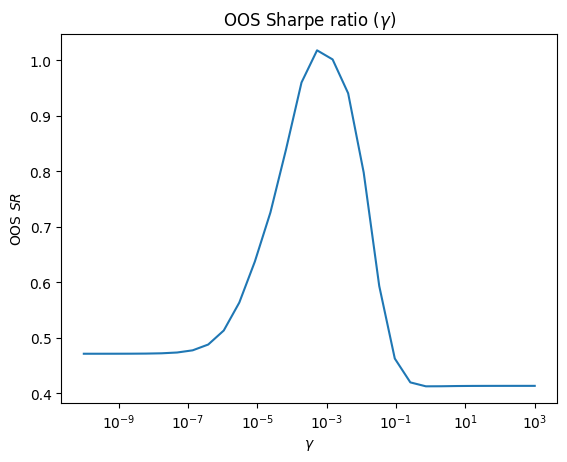

In [306]:
plot_SR(gammas,SR_OOS_split,path_figures + "oos_sr_simple_split_128.png")

In [307]:
# Compute return (excess + risk free) and save it in a Series
index_split_oos = pd.to_datetime(dates_list[IS_size + 1:]+ [pd.Timestamp('2023-12-29 00:00:00')]) 
R_P_split_max_tot = pd.Series(R_P_split_max, index = index_split_oos) + risk_free[index_split_oos]

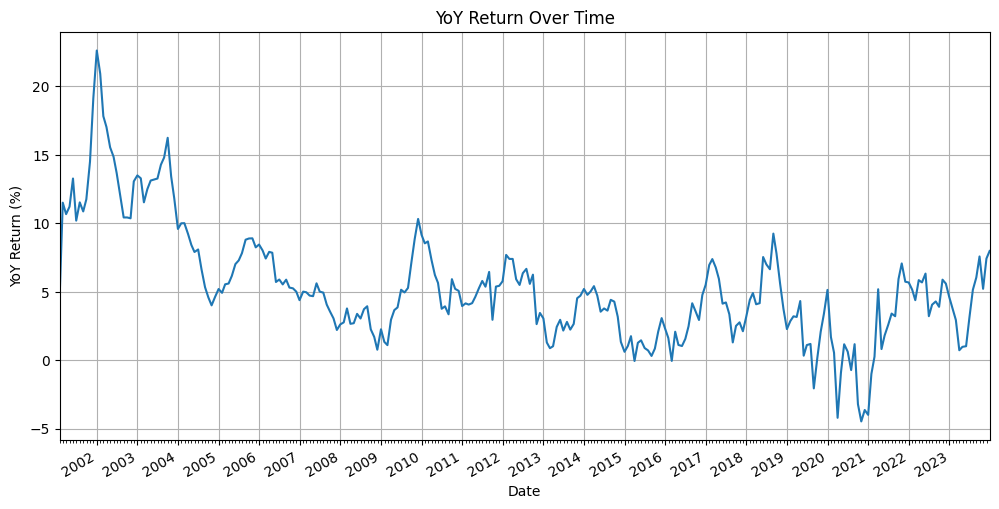

In [308]:
split_yoy_ret = plot_yoy_return_over_time(R_P_split_max_tot,path_figures + "simple_split_128_yoy_ret.png")

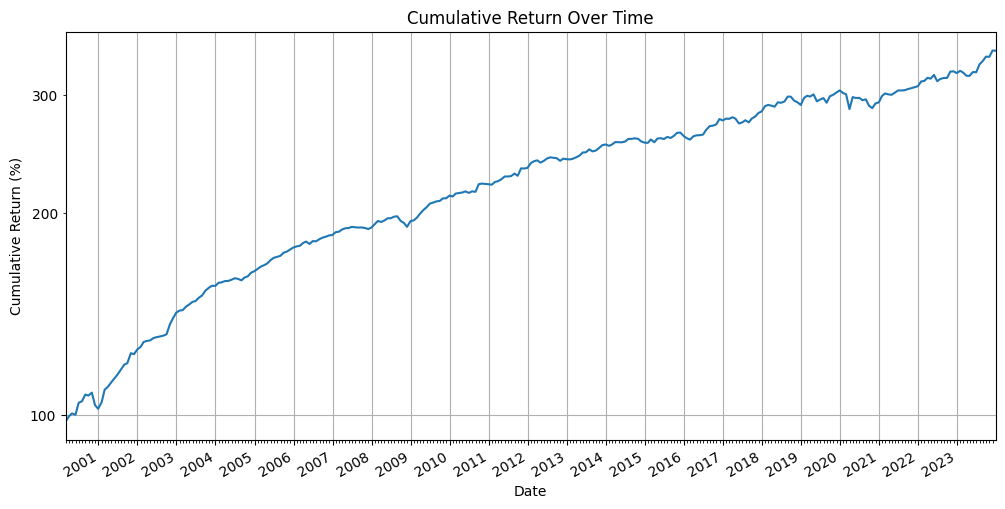

2000-02-29     97.902722
2000-03-31     99.633284
2000-04-28    100.631964
2000-05-31    100.189412
2000-06-30    104.385979
                 ...    
2023-08-31    337.606840
2023-09-29    342.538010
2023-10-31    342.361332
2023-11-30    349.833626
2023-12-29    349.612229
Length: 287, dtype: float64

In [309]:
split_cumulative_ret = plot_cumulative_return(R_P_split_max_tot,path_figures + "simple_split_128_cum_ret.png")
split_cumulative_ret

In [310]:
R_P_split_max_df = pd.Series(R_P_split_max, index = index_split_oos)
res_table_split_capm = calculate_alpha_beta(R_P_split_max_df,mkt,path_figures + "summary_split_capm.csv")

Monthly Alpha: 1.12%
Monthly Alpha standard error: 0.25%
Annualized Alpha: 13.38%
Annualized Alpha standard error: 2.99%
Z-score: 4.4705
Beta: 0.43
Beta standard error: 0.0536
Standard Deviation of Residuals: 4.18%


In [311]:
res_table_split_ff = calculate_fama_french_alpha_beta(R_P_split_max_df,mkt,fama_french, path_figures + "summary_split_ff.csv")

Monthly Alpha: 0.95%
Monthly Alpha SE: 0.26%
Annualized Alpha: 11.46%
Annualized Alpha standard error: 3.06%
Z-score: 3.7408
Betas:
  mktrf: 0.4091
  smb: 0.2867
  hml: 0.1593
  rmw: 0.2022
  cma: -0.0952
Standard Deviation of Residuals: 4.05%


## Rolling Window

In [312]:
R_P_rolling, SR_rolling, R_P_rolling_max = rolling_window_SDF(F, W, dates_list, rolling_window_size, L, activation, normalize, gammas, xi)

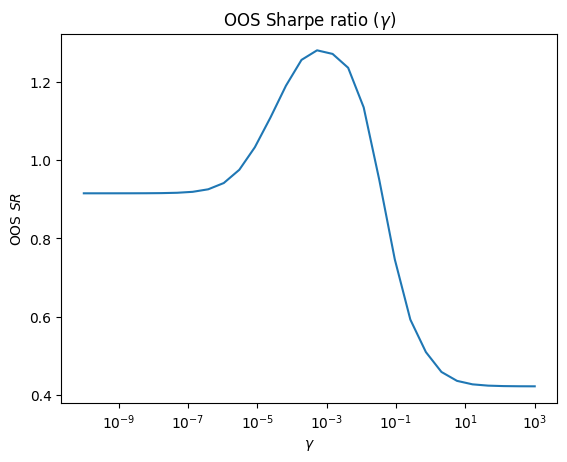

In [313]:
plot_SR(gammas, SR_rolling, path_figures + "oos_sr_rolling_128.png")

In [314]:
np.max(SR_rolling)

1.2808539442269047

In [315]:
# Compute return (excess + risk free) and save it in a Series
index_rolling_oos = pd.to_datetime(dates_list[rolling_window_size + 1:]+ [pd.Timestamp('2023-12-29 00:00:00')])
R_P_rolling_max_df = pd.Series(R_P_rolling_max, index = index_rolling_oos)
R_P_rolling_max_tot = R_P_rolling_max_df + risk_free[index_rolling_oos]

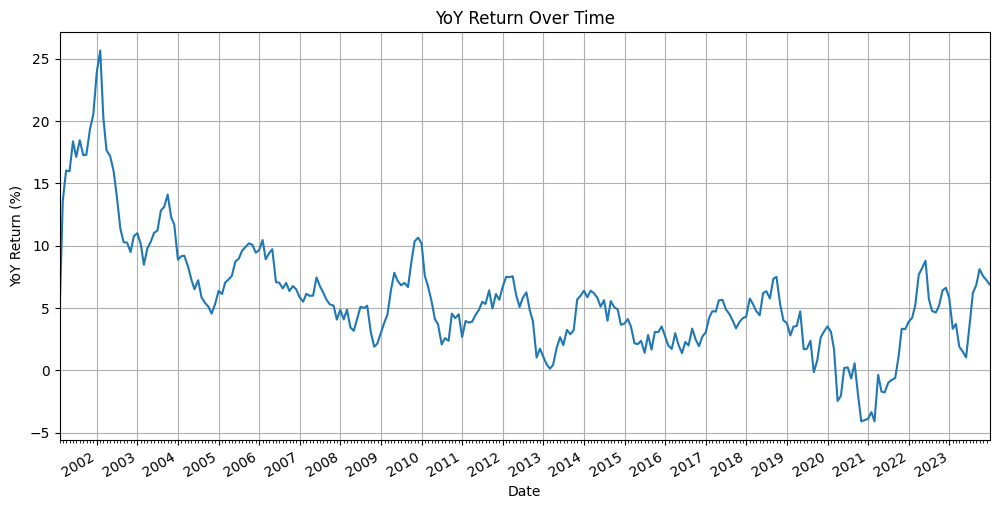

In [316]:
rolling_yoy_ret = plot_yoy_return_over_time(R_P_rolling_max_tot,path_figures + "rolling_128_yoy_ret.png")

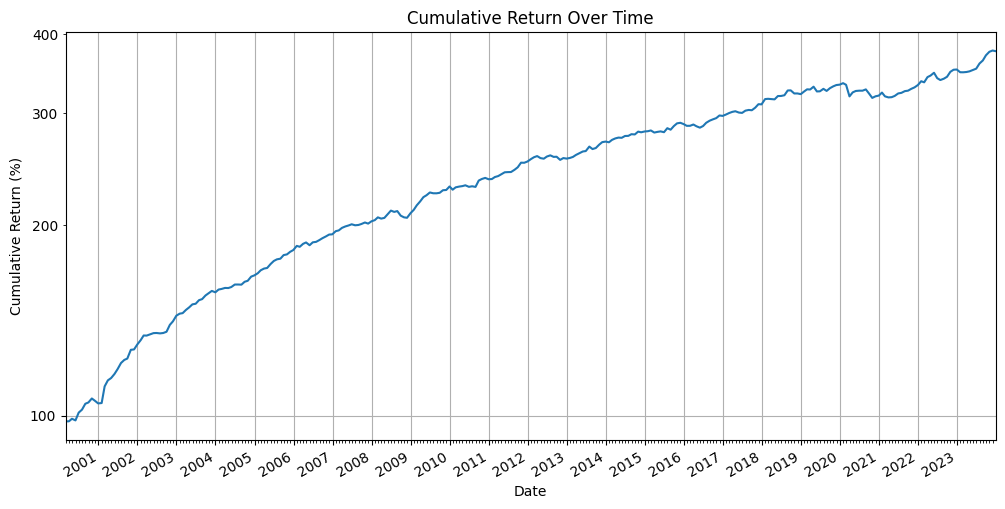

2000-02-29     97.902722
2000-03-31     97.956615
2000-04-28     98.855147
2000-05-31     98.268619
2000-06-30    101.081625
                 ...    
2023-08-31    363.162414
2023-09-29    370.023023
2023-10-31    374.780820
2023-11-30    376.527717
2023-12-29    375.634843
Length: 287, dtype: float64

In [317]:
rolling_cumulative_ret = plot_cumulative_return(R_P_rolling_max_tot,path_figures + "rolling_128_cum_ret.png")
rolling_cumulative_ret

In [318]:
res_table_rolling_capm = calculate_alpha_beta(R_P_rolling_max_df,mkt, path_figures + "summary_rolling_capm.csv")

Monthly Alpha: 1.57%
Monthly Alpha standard error: 0.27%
Annualized Alpha: 18.79%
Annualized Alpha standard error: 3.20%
Z-score: 5.8650
Beta: 0.25
Beta standard error: 0.0574
Standard Deviation of Residuals: 4.47%


In [319]:
res_table_rolling_ff = calculate_fama_french_alpha_beta(R_P_rolling_max_df,mkt,fama_french, path_figures + "summary_rolling_ff.csv")

Monthly Alpha: 1.14%
Monthly Alpha SE: 0.27%
Annualized Alpha: 13.71%
Annualized Alpha standard error: 3.21%
Z-score: 4.2716
Betas:
  mktrf: 0.3325
  smb: 0.3385
  hml: -0.1139
  rmw: 0.5230
  cma: 0.2796
Standard Deviation of Residuals: 4.25%


## Different number of factors

In [320]:
SR_OOS_all = different_number_factors_SDF(F, W, dates_list, rolling_window_size, d, multipliers, activation, normalize, gammas, xi)

Finished processing multiplier: 0.125
Finished processing multiplier: 0.25
Finished processing multiplier: 0.5
Finished processing multiplier: 1
Finished processing multiplier: 2
Finished processing multiplier: 4
Finished processing multiplier: 8
Finished processing multiplier: 16
Finished processing multiplier: 32
Finished processing multiplier: 64
Finished processing multiplier: 128


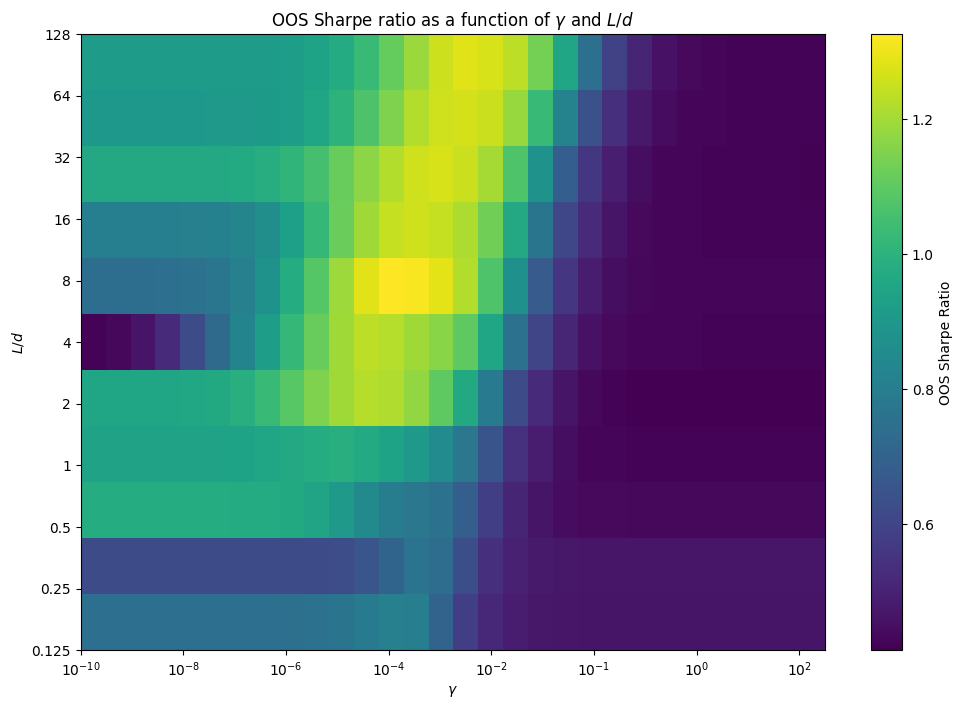

In [321]:
plot_different_number_factors(SR_OOS_all, gammas, multipliers,path_figures + "oos_sr_rolling_128_gamma_Ld.png")

In [322]:
np.max(SR_OOS_all)

1.3258282960784358

## Cross Validation Rolling Window

In [323]:
R_P_OOS_cv, SR_OOS_cv, optimal_gammas = rolling_cv_SDF(F, W, dates_list, rolling_window_size, gammas, activation, normalize, k_folds = 5, xi = xi)

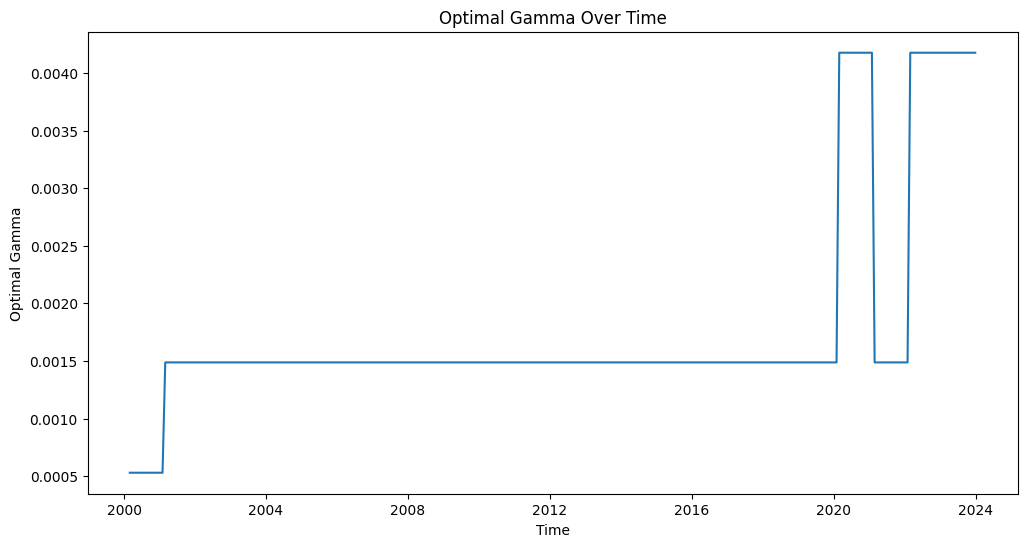

OOS Sharpe ratio:  1.2755933497412049


In [324]:
# Plot the optimal gammas over time
plt.figure(figsize=(12, 6))
plt.plot(index_rolling_oos, optimal_gammas)
plt.xlabel('Time')
plt.ylabel('Optimal Gamma')
plt.title('Optimal Gamma Over Time')
plt.savefig(path_figures + "cv_128_gamma.png", format='png', dpi=300)
plt.show()

print("OOS Sharpe ratio: ", SR_OOS_cv)

In [325]:
# Compute return (excess + risk free) and save it in a Series
R_P_OOS_cv_df = pd.Series(R_P_OOS_cv, index = index_rolling_oos)
R_P_OOS_cv_tot = R_P_OOS_cv_df + risk_free[index_rolling_oos]

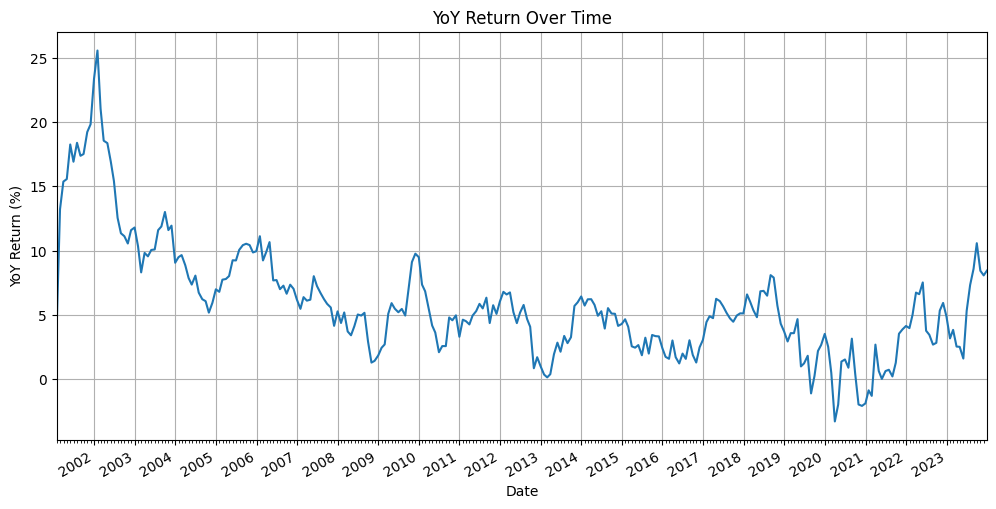

In [326]:
cv_yoy_ret = plot_yoy_return_over_time(R_P_OOS_cv_tot, path_figures + "cv_128_yoy_ret.png")

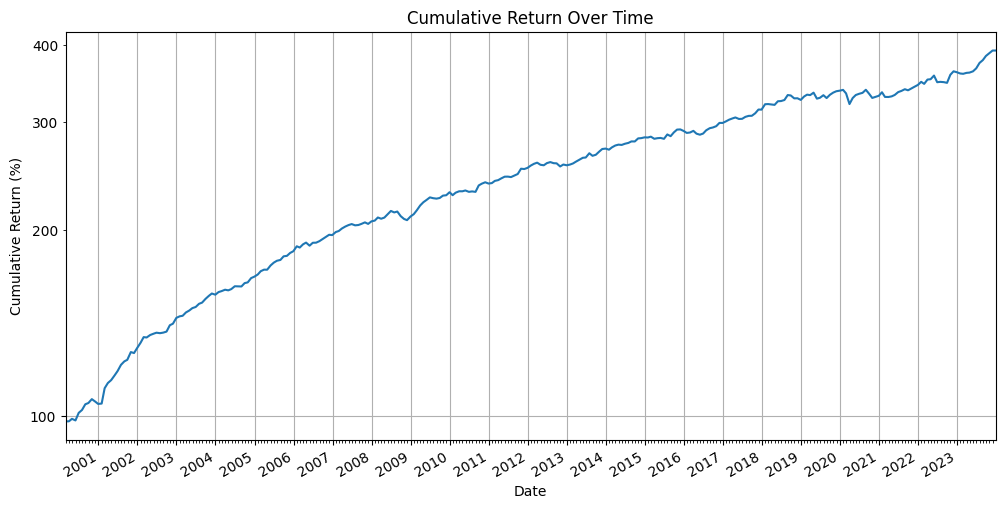

2000-02-29     97.902722
2000-03-31     97.956615
2000-04-28     98.855147
2000-05-31     98.268619
2000-06-30    101.081625
                 ...    
2023-08-31    377.963573
2023-09-29    383.892169
2023-10-31    388.010193
2023-11-30    391.729330
2023-12-29    391.767293
Length: 287, dtype: float64

In [327]:
cv_cumulative_ret = plot_cumulative_return(R_P_OOS_cv_tot, path_figures + "cv_128_cum_ret.png")
cv_cumulative_ret

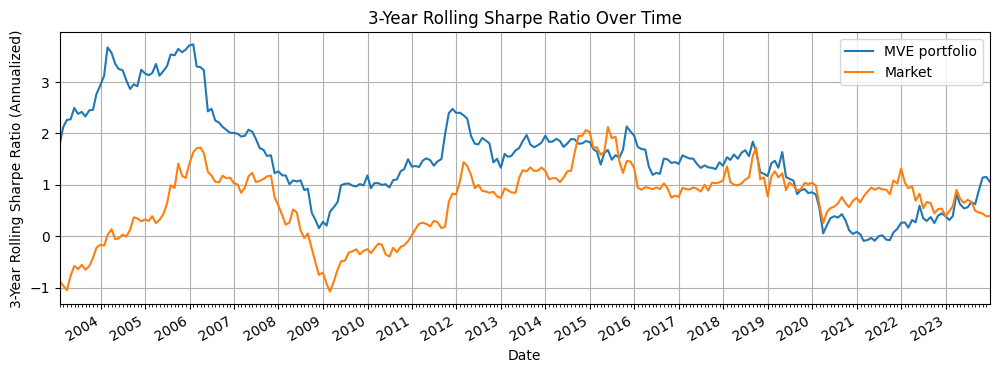

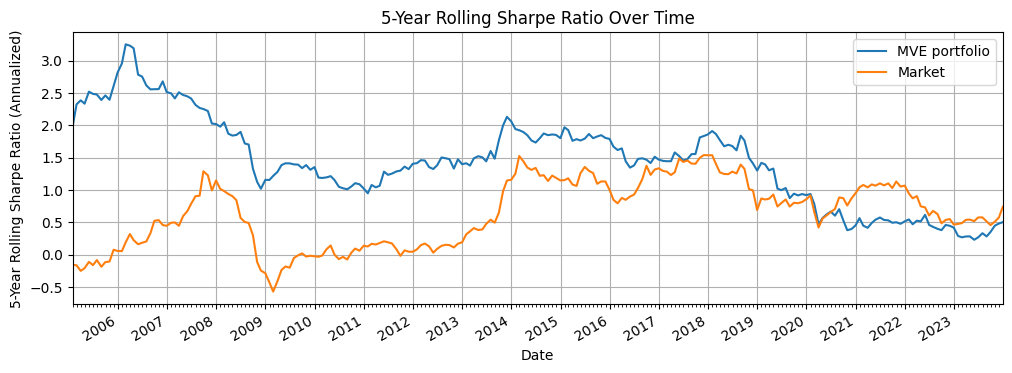

In [328]:
n_years = 3
rolling_cv_sr_3 = plot_rolling_sharpe_ratio(R_P_OOS_cv_df,n_years, path_figures + f"{n_years}yr_rolling_sr.png",mkt)
n_years = 5
rolling_cv_sr_5 = plot_rolling_sharpe_ratio(R_P_OOS_cv_df,n_years, path_figures + f"{n_years}yr_rolling_sr.png",mkt)

In [329]:
res_table_cv_capm = calculate_alpha_beta(R_P_OOS_cv_df,mkt,path_figures + "summary_cv_capm.csv")

Monthly Alpha: 1.50%
Monthly Alpha standard error: 0.26%
Annualized Alpha: 18.06%
Annualized Alpha standard error: 3.11%
Z-score: 5.8140
Beta: 0.34
Beta standard error: 0.0556
Standard Deviation of Residuals: 4.34%


In [330]:
res_table_cv_ff = calculate_fama_french_alpha_beta(R_P_OOS_cv_df,mkt,fama_french, path_figures + "summary_cv_ff.csv")

Monthly Alpha: 0.98%
Monthly Alpha SE: 0.25%
Annualized Alpha: 11.76%
Annualized Alpha standard error: 3.01%
Z-score: 3.9095
Betas:
  mktrf: 0.4563
  smb: 0.3882
  hml: -0.1616
  rmw: 0.6919
  cma: 0.2909
Standard Deviation of Residuals: 3.98%
